<div style="font-size:1.4em; margin-bottom:2em">
    <div style="float:right; line-height:1.2em;">GET Lab<br />Paderborn University</div>
  <div>SS 2021</div>
</div>
<div style="clear:both"></div>
<div style="text-align:center; font-size:1.8em;">
  Digital Image Processing II<br />Task Sheet 8
</div>

<hr>

### Overview

The objective of this exercise is to continue with optical flow estimation based on the *optical flow equation*:

$$I_x u + I_y v + I_t = 0$$

As we have one equation with two unknowns (the optical flow components $u$ and $v$), optical flow estimation is an under-determined problem. In the Lucas-Kanade method (see last task sheet), an additional *local* constraint – namely that the optical flow is similar in small local image regions – has been used to get an over-determined linear equation system for each pixel.
 
In comparison, the <a href="http://engineering.nyu.edu/~gerig/CS-GY-6643-S2016/Materials/Horn-Schunck-1981-orig-article.pdf">Horn-Schunck method (1981)</a> uses an additional *global* constraint. As a result, it can be classified as a global method.

---

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

dpi = plt.rcParams['figure.dpi']

# plot image in original size
def plot_img_orig(img):
    fig = plt.figure(figsize = (img.shape[1]/dpi, img.shape[0]/dpi))
    fig.add_axes([0, 0, 1, 1])
    plt.axis('off')
    plt.imshow(img, cmap='gray', vmin=0, vmax=255) # cmap parameter is ignored for RGB(A) data
    plt.show()

#### <span style="color: RoyalBlue; font-weight: bold;">Task 8.1</span> Horn-Schunck Method

Based on an error function, the basis of the Horn-Schunck method is the following pair of iterative equations (the iterator is denoted $k$, see lecture notes for details):

$$u^{k+1} = \bar{u}^k - I_x \dfrac{I_x\bar{u}^k+I_y\bar{v}^k+I_t}{\lambda + I_x^2 + I_y^2}$$
$$v^{k+1} = \bar{v}^k - I_y \dfrac{I_x\bar{u}^k+I_y\bar{v}^k+I_t}{\lambda + I_x^2 + I_y^2}$$

The method can be summarized as follows:
1. Compute the derivatives $I_x$, $I_y$ and $I_t$, for example using the volumetric scheme from the lecture notes.
2. Initialize $u(x,y)$ and $v(x,y)$ with zeros.
3. Run the iterations to compute $u^k$ and $v^k$ until a criterion is met.

Implement / solve the following tasks:
1. Complete the given function `neighbor_average` so that it can be used to compute the values $\bar{u}$ and $\bar{v}$. 
2. Implement the Horn-Schunck method as described above using the given function template `hs_optical_flow`.
3. Compute the optical flow for different test images and parameters (e.g., $\lambda = 100$ and 10, 25, 50 and 100 iterations).

Note: Image borders can be neglected. It can be helpful to implement a separate function to plot the optical flow fields.

I_x:


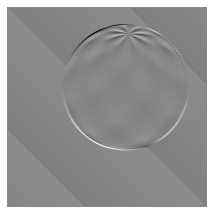

I_y:


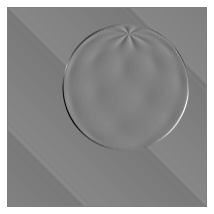

I_t:


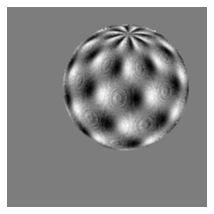

lambda = 100, iterations = 10:


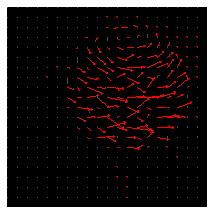

lambda = 100, iterations = 25:


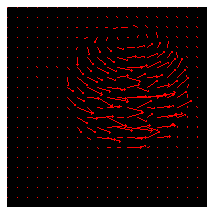

lambda = 100, iterations = 50:


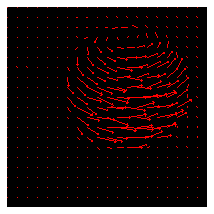

lambda = 100, iterations = 100:


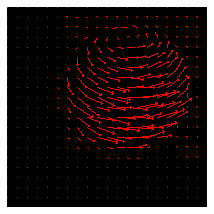

In [3]:
# write your code here

# compute the weighted average of neighboring pixels at given position i, j
def neighbor_average(img, i, j):
    avrg = (1/6) * (img[i-1, j] + img[i, j+1] + img[i+1, j] + img[i, j-1]) \
         + (1/12) * (img[i-1, j-1] + img[i-1, j+1] + img[i+1, j+1] + img[i+1, j-1])
    
    return avrg

# Horn-Schunck Method for two images and n iterations
def hs_optical_flow(img1, img2, lamb, n, plots=False):
    rows, cols = img1.shape # assume same size for images
    
    # typecasting for intermediate summations
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    
    # empty images for the derivatives
    ix = np.zeros((rows, cols), dtype=np.float64) # derivative wrt x
    iy = np.zeros((rows, cols), dtype=np.float64) # derivative wrt y
    it = np.zeros((rows, cols), dtype=np.float64) # derivative wrt t
    
    # compute the derivatives (leave out the border)
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            ix[i, j] = 0.25 * (img1[i+1, j] + img2[i+1, j] + img1[i+1, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img2[i, j] + img1[i, j+1] + img2[i, j+1])

            iy[i, j] = 0.25 * (img1[i, j+1] + img2[i, j+1] + img1[i+1, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img2[i, j] + img1[i+1, j] + img2[i+1, j]) \
            
            it[i, j] = 0.25 * (img2[i, j] + img2[i+1, j] + img2[i, j+1] + img2[i+1, j+1]) \
                      -0.25 * (img1[i, j] + img1[i+1, j] + img1[i, j+1] + img1[i+1, j+1])
            
    # plot of the normalized derivatives
    if plots:
        print("I_x:"); plot_img_orig(cv2.normalize(ix, None, 0, 255, cv2.NORM_MINMAX))
        print("I_y:"); plot_img_orig(cv2.normalize(iy, None, 0, 255, cv2.NORM_MINMAX))
        print("I_t:"); plot_img_orig(cv2.normalize(it, None, 0, 255, cv2.NORM_MINMAX))

    # initialize u(x,y) and v(x,y) with zeros for iteration k (last) and k+1 (current) 
    u_last = np.zeros((rows, cols), dtype=np.float64) # k
    v_last = np.zeros((rows, cols), dtype=np.float64)
    
    u_curr = np.zeros((rows, cols), dtype=np.float64) # curr = current = k+1
    v_curr = np.zeros((rows, cols), dtype=np.float64)
    
    for k in range(n): # number of iterations
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                # weighted average of neighboring pixels
                u_avg = neighbor_average(u_last, i, j)
                v_avg = neighbor_average(v_last, i, j)
                
                # right part (rp) of the equations
                rp = (ix[i, j]*u_avg + iy[i, j]*v_avg + it[i, j]) / (lamb + ix[i, j]*ix[i, j] + iy[i, j]*iy[i, j])

                # compute u^(k+1) and v^(k+1)
                u_curr[i, j] = u_avg - ix[i, j] * rp
                v_curr[i, j] = v_avg - iy[i, j] * rp
                
        # update u and v for next iteration
        u_last = u_curr
        v_last = v_curr
    
    # data structure for the resulting optical flow field
    res = np.zeros((rows, cols, 2), dtype=np.float64) # u and v components (each is one channel)

    res[:,:,0] = u_last
    res[:,:,1] = v_last
            
    return res

# plot given optical flow field in given image or separately
# of = two channel flow image, img = gray image to overlay flow, d = distance between flow arrows
def plot_of(of, img=None, d=10):
    rows = int(of.shape[0]); cols = int(of.shape[1]) # get image size
    
    # check if the flow field should be overlayed
    if img == None:
        img_of = np.zeros((rows, cols, 3), dtype=np.uint8)
    else:
        img_of = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    fac = 10.0 # scaling factor for the length of the arrows
    for i in range(0, rows, d):
        for j in range(0, cols, d):
            pt1 = (int(j), int(i)) # note that x is the horizontal axis in opencv
            pt2 = (int(j + fac*of[i, j, 1]), int(i + fac*of[i, j, 0]))
            
            # draw optical flow arrows
            cv2.arrowedLine(img_of, pt1, pt2, color=(255, 0, 0))

    # plot the result
    plot_img_orig(img_of)
        

# read images as grayscale images (parameter 0)
img1 = cv2.imread('images/sphere/00.png', 0)
img2 = cv2.imread('images/sphere/01.png', 0)

# compute and plot the optical flow field for different parameters
of = hs_optical_flow(img1, img2, 100, 10, True)
print("lambda = 100, iterations = 10:")
plot_of(of)

of = hs_optical_flow(img1, img2, 100, 25)
print("lambda = 100, iterations = 25:")
plot_of(of)

of = hs_optical_flow(img1, img2, 100, 50)
print("lambda = 100, iterations = 50:")
plot_of(of)

of = hs_optical_flow(img1, img2, 100, 100)
print("lambda = 100, iterations = 100:")
plot_of(of)